# Tutorial 4: Convolutional Neural Networks

In [39]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

%matplotlib inline

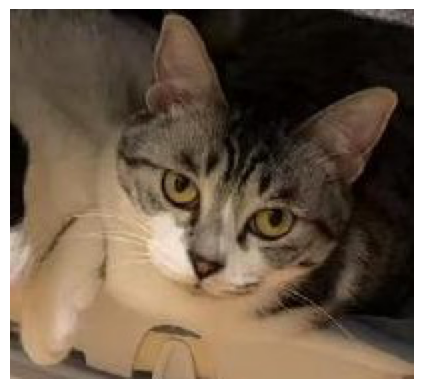

In [40]:
img = Image.open("cat.jpg")
# img = img.convert('L')  # convert to gray image. 'L' means luminance
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Convolutions

In [41]:
conv = nn.Conv2d(in_channels=1, 
                 out_channels=2, 
                 kernel_size=3, 
                 stride=1, 
                 bias=False,
                 padding=0,
                 )
kernel = list(conv.parameters())[0]

In [42]:
conv

Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [43]:
kernel.shape  # (out, in, kernel_size, kernel_size)

torch.Size([2, 1, 3, 3])

In [44]:
image_path = 'cat.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((480, 480)),  # Resize the image to fit model input size
    transforms.ToTensor(),            # Convert PIL image to tensor
    # transforms.Normalize()
])
x = preprocess(img).unsqueeze(0)  # Add batch dimension

In [45]:
images = [x, x]

torch.cat(images).shape

torch.Size([2, 3, 480, 480])

In [46]:
x.shape  # (batch_size, channel, height, width) == NCHW format

torch.Size([1, 3, 480, 480])

PyTorch uses the NCHW format for the convolutional layers

In [47]:
x.shape

torch.Size([1, 3, 480, 480])

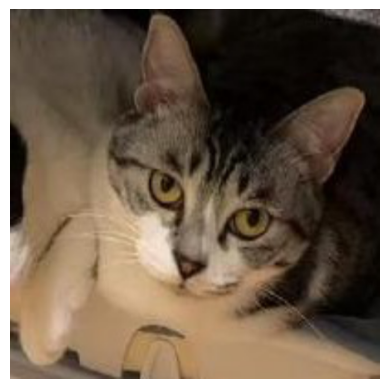

In [48]:
to_pil = transforms.ToPILImage()
output = to_pil(x.squeeze(0))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

In [49]:
kernel_size = 25

# in_channels = 3 because the input image has three channels: RGB
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=1, 
                       kernel_size=kernel_size, 
                       padding='same', # or 'valid' or a non-negative integer
                       bias=False)

In [50]:
conv_layer.weight.data.shape

torch.Size([1, 3, 25, 25])

In [51]:
y = conv_layer(x)

In [52]:
y.shape

torch.Size([1, 1, 480, 480])

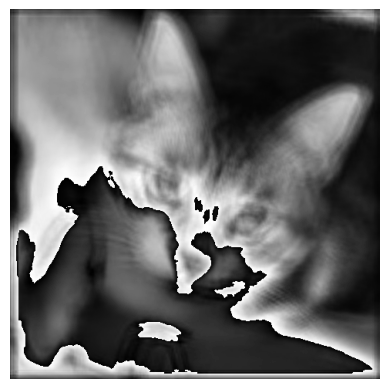

In [53]:
to_pil = transforms.ToPILImage()
output = to_pil(y.squeeze(0))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

## Padding

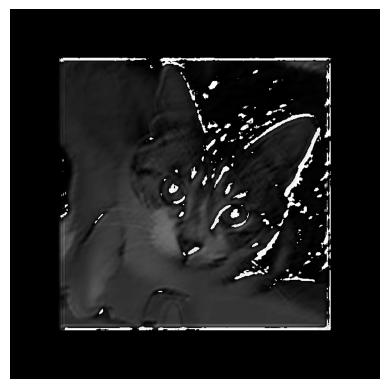

In [54]:
kernel_size = 13
padding = 100
conv_layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
y = conv_layer(x)
to_pil = transforms.ToPILImage()
output = to_pil(y.squeeze(0))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

In [55]:
y.shape

torch.Size([1, 1, 668, 668])

## Strided Convolution

torch.Size([1, 1, 115, 115])


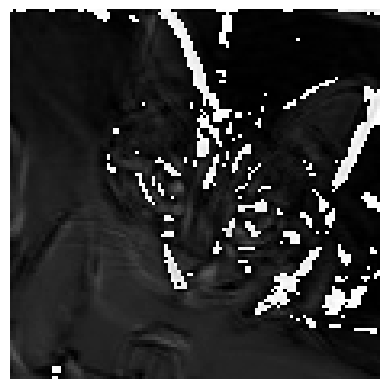

In [56]:
kernel_size = 25
padding = 6
stride = 4
conv_layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=kernel_size, padding=1, stride=stride, bias=False)
y = conv_layer(x)
print(y.shape)
to_pil = transforms.ToPILImage()
output = to_pil(y.squeeze(0))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

## Pooling

In [57]:
pool = nn.MaxPool2d(kernel_size=10, stride=1)
z = pool(y)
z.shape


torch.Size([1, 1, 106, 106])

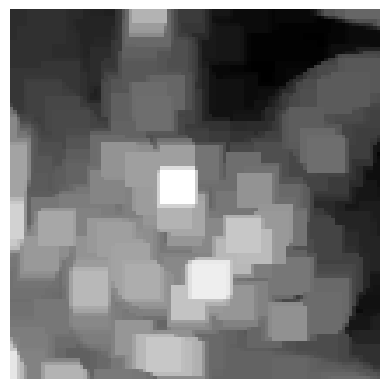

In [58]:
to_pil = transforms.ToPILImage()
output = to_pil(z.squeeze(0))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

## MNIST

In [59]:
from torchvision import datasets

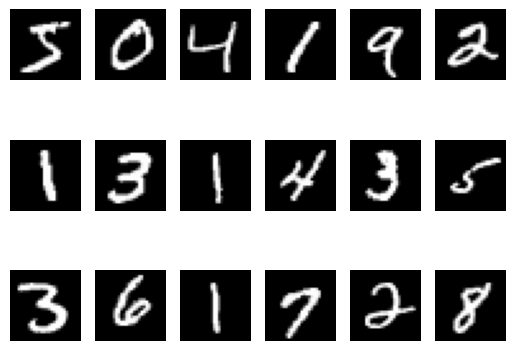

In [60]:
# plot the first 18 images in the training data
mnist = datasets.MNIST('data', download=True, train=True)
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(list(mnist)[:18]):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [61]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=4, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc = nn.Linear(4 * 4 * 4, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

Input Image (1 channel)
   ↓
Convolution (5 filters, 5×5)
   ↓
ReLU Activation (introduce non-linearity)
   ↓
Max Pooling (2×2, downsample features)
   ↓
Output (5 feature maps, smaller spatial size)

In [62]:
model = MNIST_CNN()

In [63]:
lr = 1e-3
epochs = 5
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    # transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

mnist_train = datasets.MNIST('data', download=True, train=True, transform=transform)
mnist_test = datasets.MNIST('data', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss = []
    # Training step
    for i, (data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    # Evaluate the training and test accuracy
    test_loss = []
    test_accuracy = []
    for i, (data, labels) in enumerate(test_loader):
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
    print(f'Epoch: {epoch}, train loss: {np.mean(train_loss)}, test loss: {np.mean(test_loss)}, test accuracy: {np.mean(test_accuracy)}')

100%|██████████| 938/938 [00:17<00:00, 54.70it/s]


Epoch: 0, train loss: 0.523535651716787, test loss: 0.2202872875010132, test accuracy: 0.9336186305732485


100%|██████████| 938/938 [00:21<00:00, 44.12it/s]


Epoch: 1, train loss: 0.19937379110548922, test loss: 0.1478350523527071, test accuracy: 0.9530254777070064


100%|██████████| 938/938 [00:22<00:00, 41.51it/s]


Epoch: 2, train loss: 0.14790219767019153, test loss: 0.11464416674059477, test accuracy: 0.963077229299363


100%|██████████| 938/938 [00:19<00:00, 47.95it/s]


Epoch: 3, train loss: 0.12433308618429151, test loss: 0.09716171497229938, test accuracy: 0.9692476114649682


100%|██████████| 938/938 [00:20<00:00, 44.79it/s]


Epoch: 4, train loss: 0.11013408884334602, test loss: 0.0902104944192395, test accuracy: 0.9702428343949044


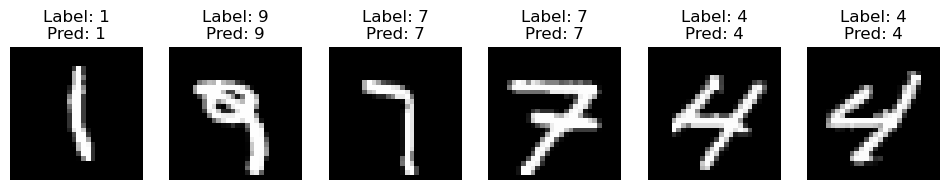

In [89]:
import random
import matplotlib.pyplot as plt

# Randomly select 6 images from the test set
def select_random_images(dataset, num_images=6):
    indices = random.sample(range(len(dataset)), num_images)
    images, labels = zip(*[dataset[i] for i in indices])
    return images, labels

# Function to display the images with predictions
def plot_images(images, labels, predictions):
    fig, axes = plt.subplots(1, 6, figsize=(12, 6))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}\nPred: {prediction}')
        axes[i].axis('off')
    plt.show()

# Set the model to evaluation mode
model.eval()

# Select 6 random images from the test set
test_images, test_labels = select_random_images(mnist_test)

# Prepare the images for prediction (convert to tensors and batch them)
test_images_tensor = torch.stack([image for image in test_images])

# Perform predictions on the selected images
with torch.no_grad():
    outputs = model(test_images_tensor)
    _, predicted_labels = torch.max(outputs, 1)

# Convert the tensors to numpy for display purposes
test_labels_np = [label for label in test_labels]
predicted_labels_np = predicted_labels.cpu().numpy()

# Display the images, true labels, and predicted labels
plot_images(test_images, test_labels_np, predicted_labels_np)


# AlexNet

Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems 25 (2012).

Cited by 134560 as of October 22, 2024.


![](https://miro.medium.com/v2/resize:fit:1400/1*0dsWFuc0pDmcAmHJUh7wqg.png)





In [90]:

# Get the weights from torch library.
# The weights are trained on ImageNet dataset.

# ImageNet dataset:
# 1000 classes, 
# 1,281,167 training images, 
# 50,000 validation images and 100,000 test images.


import torchvision.models
alexNet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [66]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [67]:
alexNet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

## AlexNet Features

In [91]:
preprocess = transforms.Compose([
    transforms.Resize(256),                             # Resize to 256x256
    transforms.CenterCrop(224),                         # Crop the center 224x224
    transforms.ToTensor(),                              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Normalize according to ImageNet
                         std=[0.229, 0.224, 0.225])
])

x = preprocess(Image.open("cat.jpg")).unsqueeze(0)
features = alexNet.features(x)

In [69]:
features

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 3.9565, 3.9565, 0.3619, 0.0000, 0.0000],
          [0.0000, 3.9565, 4.3133, 4.0491, 2.9820, 0.7287],
          [0.4274, 3.5511, 3.5511, 5.2395, 5.2395, 2.7414],
          [0.0000, 2.3807, 2.3066, 5.4398, 5.4398, 1.2096],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.7746, 1.7746, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.7746, 1.7746, 0.0000, 0.0000, 0.0000, 0.1602],
          [0.8828, 0.3437, 0.0000, 0.0000, 0.0000, 0.1602],
          [0.0529, 0.0529, 0.0000, 0

In [70]:
features.shape

torch.Size([1, 256, 6, 6])

## AlexNet First Convolution Layer

In [92]:
alexNetConv = alexNet.features[0]
y = alexNetConv(x)

In [93]:
y = y.detach().numpy()
y = (y - y.min()) / (y.max() - y.min())
y.shape

(1, 64, 55, 55)

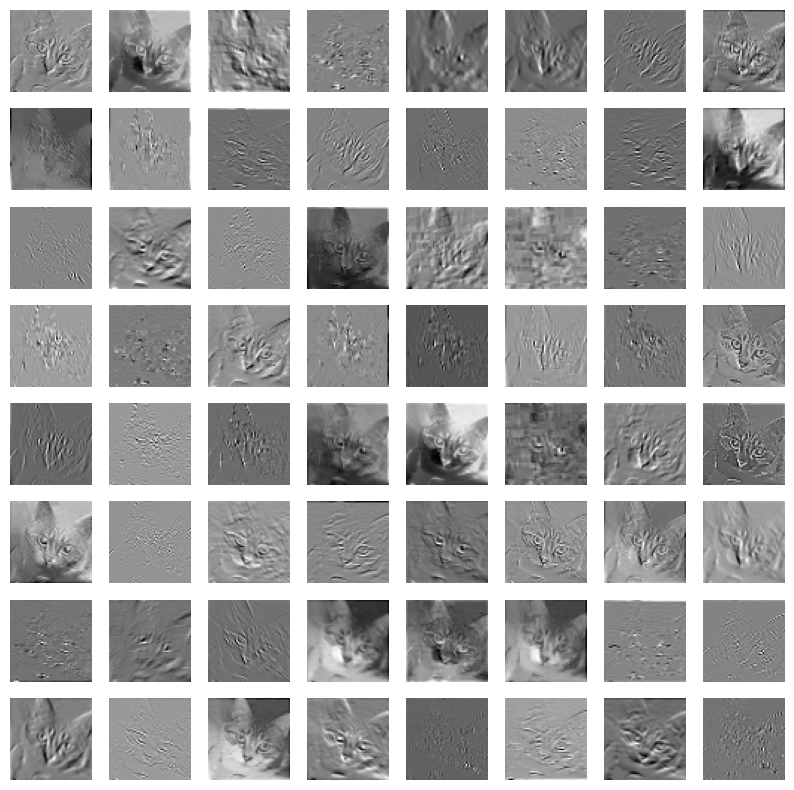

In [94]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i], cmap="gray")
    plt.axis('off')

## AlexNet After ReLU

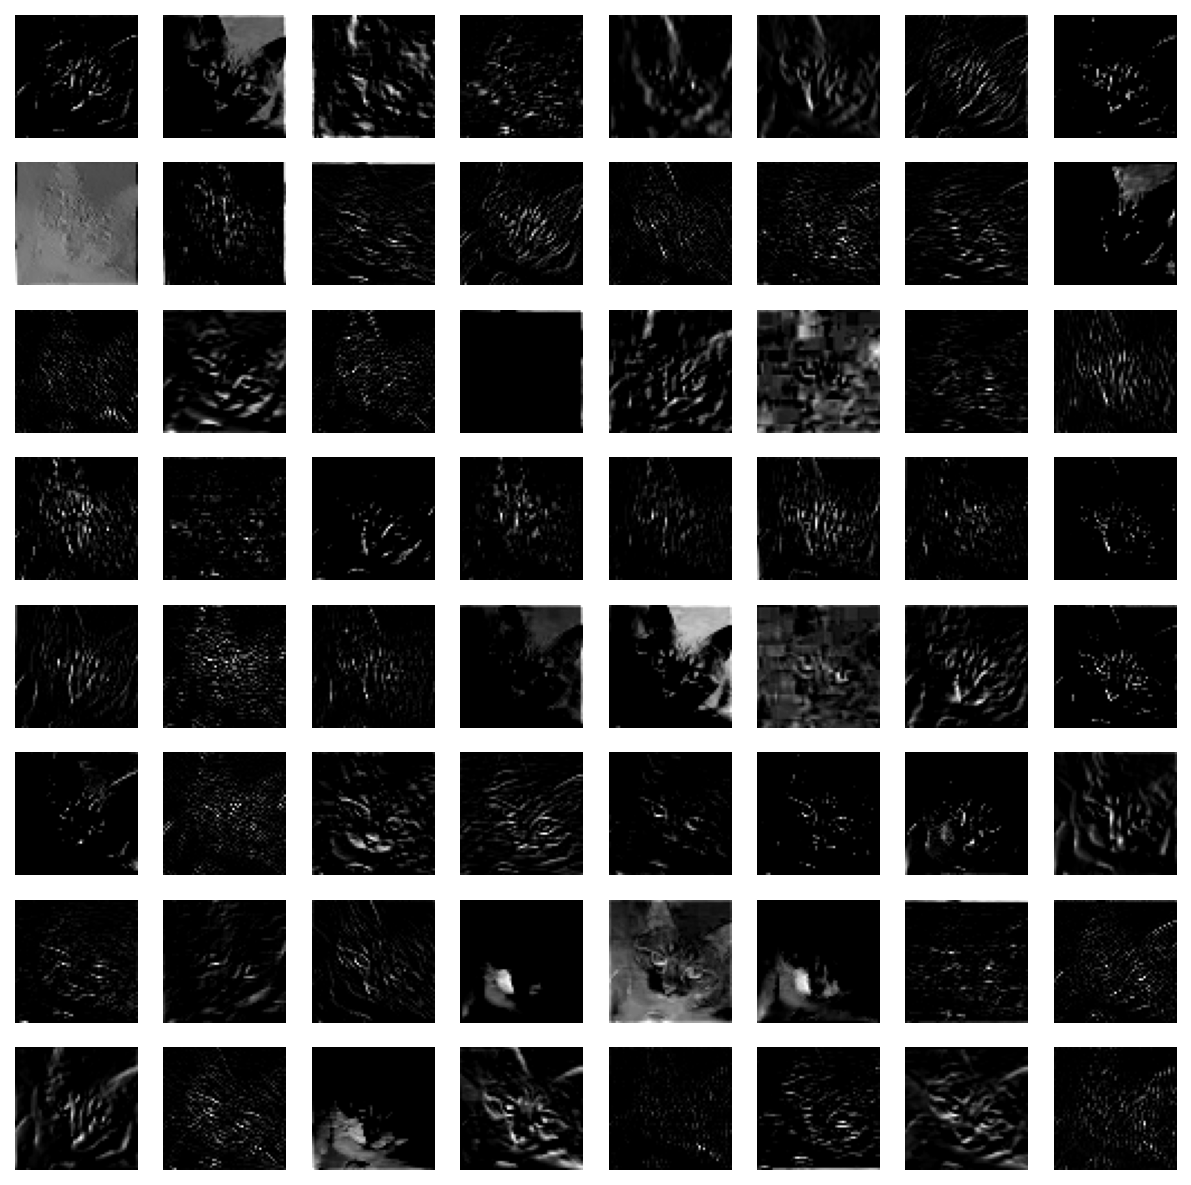

In [95]:
alexNetConv = alexNet.features[0]
y = torch.relu(alexNetConv(x))

y = y.detach().numpy()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(figsize=(10,10), dpi=150)
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i], cmap="gray")
    plt.axis('off')

## AlexNet Second Convolutions¶

In [96]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [97]:
y = alexNet.features[0](x) # first conv
y = alexNet.features[1](y) # relu
y = alexNet.features[2](y) # pooling
y = alexNet.features[3](y) # second conv
y = alexNet.features[4](y) # relu
y = alexNet.features[5](y) # pooling

y = y.detach().numpy()
y = (y - y.min()) / (y.max() - y.min())

y.shape

(1, 192, 13, 13)

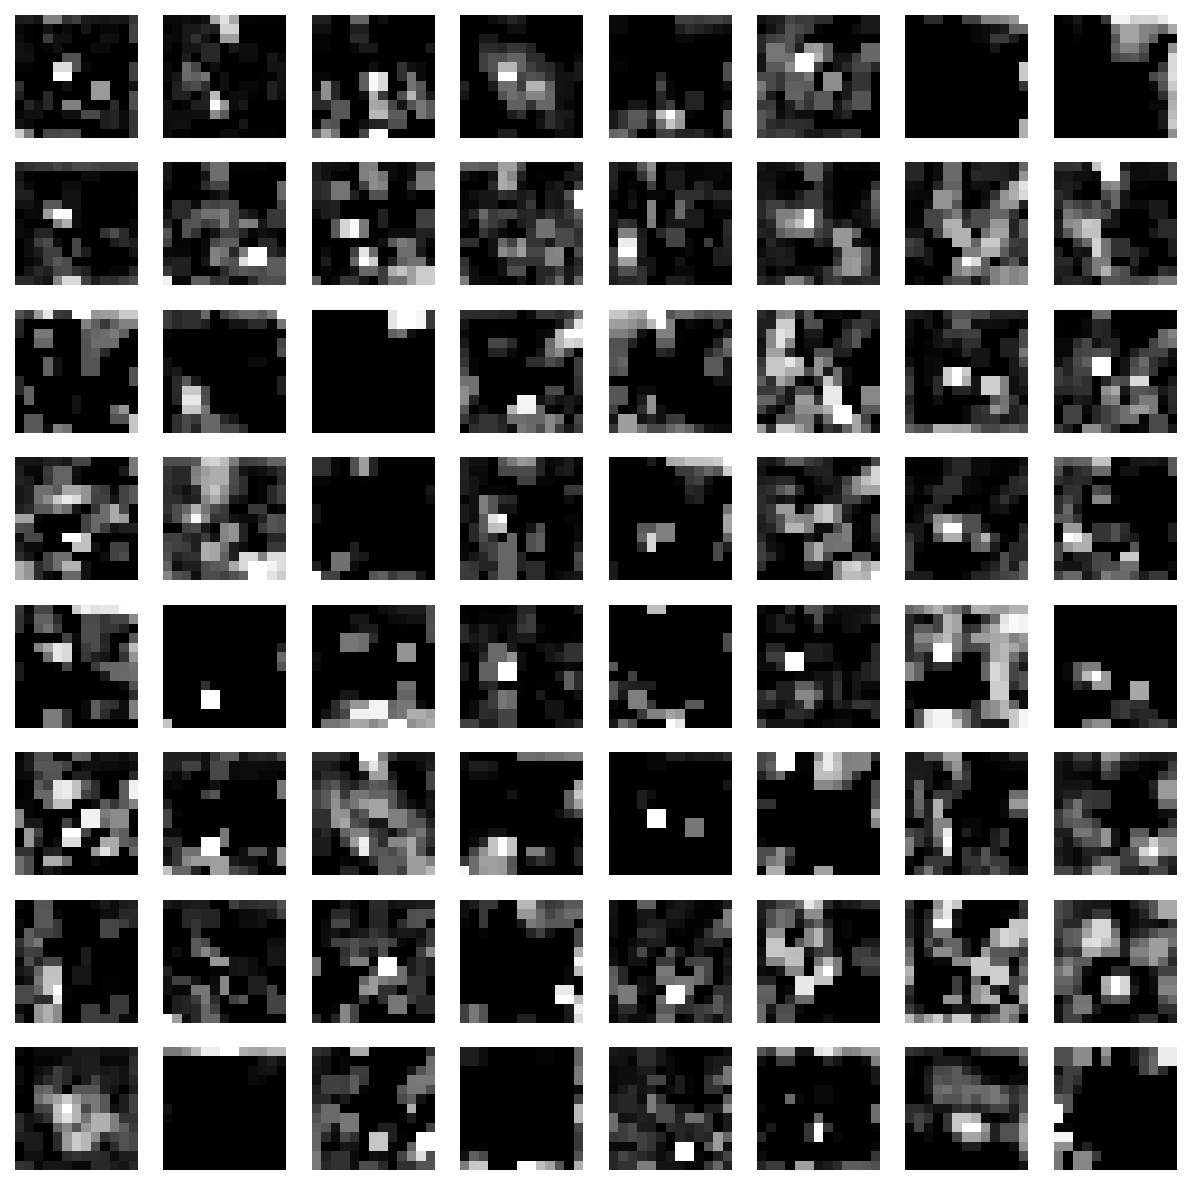

In [98]:
plt.figure(figsize=(10,10), dpi=150)
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i], cmap="gray")
    plt.axis('off')

In [99]:
alexNet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [100]:
# Perform inference
with torch.no_grad():
    output = alexNet(x)

In [101]:
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [102]:
probabilities

tensor([2.5088e-07, 3.5437e-09, 2.8885e-09, 3.6300e-08, 5.3213e-08, 1.6564e-07,
        5.1132e-10, 1.6515e-09, 3.8038e-09, 7.1434e-11, 1.4068e-09, 1.1129e-10,
        6.6482e-10, 5.2407e-10, 2.4575e-10, 9.2405e-10, 2.5797e-10, 3.3785e-10,
        6.0349e-11, 9.6247e-11, 4.4628e-09, 7.8080e-09, 1.9893e-09, 3.7346e-10,
        6.3684e-09, 4.7569e-09, 5.9282e-08, 9.8542e-10, 6.5452e-08, 7.2632e-08,
        2.0737e-08, 1.0614e-08, 1.6324e-07, 6.0621e-08, 3.8034e-08, 2.3740e-07,
        1.5076e-07, 1.1228e-08, 1.1452e-06, 1.3155e-08, 2.6397e-10, 3.0722e-08,
        4.5307e-09, 2.1219e-08, 3.1605e-07, 1.8298e-08, 2.2704e-09, 7.7380e-08,
        5.0457e-10, 1.1596e-09, 1.3868e-08, 3.9957e-07, 3.0183e-08, 3.3577e-08,
        1.0712e-07, 3.8583e-09, 3.3573e-07, 9.1949e-09, 1.3454e-08, 5.8854e-09,
        3.4801e-08, 2.6072e-07, 9.0723e-07, 1.2318e-08, 2.0910e-08, 1.5789e-08,
        1.0026e-06, 1.6079e-08, 1.1119e-07, 1.0172e-08, 1.3183e-09, 1.6127e-08,
        2.8343e-10, 4.9389e-09, 2.0722e-

In [103]:
top5_prob, top5_catid = torch.topk(probabilities, 5)

In [104]:
top5_prob

tensor([9.5414e-01, 3.4081e-02, 7.0243e-03, 2.4981e-03, 5.6335e-04])

In [105]:
top5_catid

tensor([285, 281, 282, 287, 286])

In [106]:
# Get class labels from ImageNet
import requests
labels = requests.get('https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json').json()

In [107]:
# Top 5 predicted labels for the given dog image
for cat_id in top5_catid:
    print(labels[cat_id])

Egyptian Mau
tabby cat
tiger cat
lynx
cougar
